### This document trains a classifier on the Rate My Hydrograph ratings.

The classifier gets as input the metrics of model a and b.

In [13]:
%load_ext autoreload
%autoreload 2
import torch
import itertools
from collections import defaultdict
from datetime import datetime

from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from tqdm import tqdm
from pathlib import Path
from neuralhydrology.evaluation.metrics import calculate_all_metrics, nse, kge
from neuralhydrology.evaluation.signatures import calculate_all_signatures

plt.rc('font', **{'family':'serif','serif': ['Computer Modern']})
plt.rcParams.update({"text.usetex": True,})
plt.rc('font', size=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)

df = pd.read_csv('data/rmh-stage1.csv', index_col=0)

mm_to_inch = lambda mm: mm * 0.03937008

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
areas = ['flood-modeling',
         'water-resources',
         'drought-modeling',
         'waterquality',
         'hydropower',
         'other',
         'consulting']  # 'social-sciences', 'insurance' have very few participants, so we merge them into 'other'.
areas_df = pd.DataFrame(columns=[f'focus_{a}' for a in areas], index=df.index, dtype=bool)
areas_df.loc[:, :] = False
for idx, vals in df['focus_areas'].str.split(',').iteritems():
    for v in vals:
        if v.lower() in areas:
            areas_df.loc[idx, f'focus_{v}'] = True
        else:
            areas_df.loc[idx, 'focus_other'] = True
areas_df.head()

,focus_flood-modeling,focus_water-resources,focus_drought-modeling,focus_waterquality,focus_hydropower,focus_other,focus_consulting
0,True,True,True,True,False,False,False
1,True,True,True,True,False,False,False
2,False,False,False,False,False,True,False
3,False,False,False,False,False,True,False
4,True,True,True,True,False,False,False


Load observations and predictions from the GRIP-GL study

In [6]:
def load_data(base_dir):
    obs_file = base_dir / 'all_gauges.nc'
    if not obs_file.exists():
        raise ValueError(f'Observations netCDF file not found at {obs_file}')
    # netcdfs only have a numeric dimension "nstations" that maps to the station_id variable.
    # for easier processing, we directly make the station_id the dimension.
    obs = xarray.load_dataset(obs_file).swap_dims({'nstations': 'station_id'})

    # load hydrographs from individual models
    hydrographs = {'Q': obs['Q']}
    model_dirs = [d for d in base_dir.glob('model/*') if d.is_dir()]
    for model_dir in model_dirs:
        model_name = model_dir.name
        model_nc = list(model_dir.glob('*.nc'))
        if len(model_nc) != 1:
            if len(model_nc) == 0:
                continue
        hydrographs[model_name] = xarray.open_dataset(model_nc[0]).swap_dims({'nstations': 'station_id'})['Q']

    hydrograph_xr = xarray.concat(hydrographs.values(), dim='model')
    hydrograph_xr['model'] = list(hydrographs.keys())
    return hydrograph_xr

OBJECTIVES = ['objective_1/great-lakes/validation-temporal', 'objective_2/great-lakes/validation-temporal']
XR = {obj: load_data(Path(f'data/{obj.split("/")[0]}')) for obj in OBJECTIVES}

Calculate metrics

In [7]:
metric_vals = defaultdict(dict)
for obj, model in itertools.product(OBJECTIVES, df['model_a'].unique()):
    sub_df = df[(df['objective']==obj) & ((df['model_a']==model) | (df['model_b']==model))]
    basins_dates = sub_df[['basin', 'start_date', 'end_date']].drop_duplicates()
    for _, (basin, start_date, end_date) in basins_dates.iterrows():
        sub_xr = XR[obj].sel(station_id=basin, time=slice(start_date, end_date))
        setting_metrics = calculate_all_metrics(sub_xr.sel(model='Q'), sub_xr.sel(model=model), datetime_coord='time')
        setting_metrics['logNSE'] = nse(np.log(sub_xr.sel(model='Q') + 1e-5), np.log(sub_xr.sel(model=model) + 1e-5))
        setting_metrics['logKGE'] = kge(np.log(sub_xr.sel(model='Q') + 1e-5), np.log(sub_xr.sel(model=model) + 1e-5))
        for metric, val in setting_metrics.items():
            metric_vals[metric][(obj, model, basin, start_date)] = val

metric_vals = pd.DataFrame(metric_vals)
metric_vals.index = metric_vals.index.set_names(('objective', 'model', 'basin', 'start_date'))

/system/apps/mlsoft/conda/group-bioinf/gauch/envs/cf/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/system/apps/mlsoft/conda/group-bioinf/gauch/envs/cf/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/system/apps/mlsoft/conda/group-bioinf/gauch/envs/cf/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/system/apps/mlsoft/conda/group-bioinf/gauch/envs/cf/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/system/apps/mlsoft/conda/group-bioinf/gauch/envs/cf/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/system/apps/mlsoft/

Add metrics to the ratings dataframe

In [8]:
metric_df = df.copy()
input_cols_metrics = []
for ab in ['a', 'b']:
    for metric in metric_vals.columns:
        input_cols_metrics.append(f'model_{ab}_{metric}')
        metric_df[input_cols_metrics[-1]] = np.nan
for idx in metric_df.index:
    obj = metric_df.loc[idx, 'objective']
    basin = metric_df.loc[idx, 'basin']
    start_date = metric_df.loc[idx, 'start_date']
    for metric in metric_vals.columns:
        for ab in ['a', 'b']:
            model = metric_df.loc[idx, f'model_{ab}']
            metric_df.loc[idx, f'model_{ab}_{metric}'] = metric_vals.loc[(obj, model, basin, start_date), metric]

Prepare input and target arrays

In [9]:
target_names = ['num_a_wins', 'num_b_wins', 'num_equal_good', 'num_equal_bad']

print(f'Dropping columns with NaNs: {", ".join(metric_df[input_cols_metrics].columns[pd.isna(metric_df[input_cols_metrics]).any(axis=0)])}')
input_cols_metrics = [c for c in input_cols_metrics if not pd.isna(metric_df[input_cols_metrics]).any(axis=0)[c]]
input_cols = input_cols_metrics

x_in = pd.concat([metric_df[input_cols_metrics], pd.get_dummies(df['task'])], axis=1)
y = pd.Series(np.argmax(metric_df[target_names].astype(int).values, axis=1), index=x_in.index)

x_in.shape, y.shape

Dropping columns with NaNs: 


((14586, 33), (14586,))

In [10]:
def run(n_estimators=1000, max_depth=10, run_test=False):
    models = {}
    targets = target_names
    for task in df['task'].unique():
        np.random.seed(0)
        torch.manual_seed(0)

        print(f'\n####################################################################################\n{task.upper()}')
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0, n_jobs=-1)

        # Select ratings from the current task
        drop_vars = df['task'].unique().tolist()
        y_sub = y[x_in[task] == 1]
        x_sub = x_in[x_in[task] == 1].drop(drop_vars, axis=1)
        
        # Run 5-fold CV
        shuffled_indices = np.random.permutation(x_sub.index.values)
        kf = KFold(n_splits=5, shuffle=False)
        confusions = []
        reports = []
        test_reports = []
        for i, (idx_train, idx_test) in enumerate(kf.split(x_sub.loc[shuffled_indices].values)):
            
            # Further split train set into train & val
            n_train = int(idx_train.shape[0] * 0.8)
            idx_train, idx_val = idx_train[:n_train], idx_train[n_train:]

            scale = x_sub.iloc[idx_train].std(axis=0)
            loc = x_sub.iloc[idx_train].mean(axis=0)

            if i == 0:
                print(f'{len(idx_train)} training samples, {len(idx_val)} validation, {len(idx_test)} test samples, {x_sub.shape[1]} features.')

            model.fit((x_sub.iloc[idx_train] - loc) / scale, y_sub.iloc[idx_train])
            models[(i, task)] = model

            y_hat_val = model.predict((x_sub.iloc[idx_val] - loc) / scale)
            y_hat_test = model.predict((x_sub.iloc[idx_test] - loc) / scale)
            
            # Generate classification metrics
            confusions.append(confusion_matrix(y_sub.iloc[idx_val], y_hat_val, normalize='pred', labels=list(range(len(targets)))))
            reports.append(classification_report(y_sub.iloc[idx_val], y_hat_val, target_names=targets, output_dict=True, zero_division=0))
            if run_test:
                test_reports.append(classification_report(y_sub.iloc[idx_test], y_hat_test, target_names=targets, output_dict=True, zero_division=0))
        
        print(f'Avg validation accuracy: {np.mean([rep["accuracy"] for rep in reports]):.3f}')
        display(sum(pd.DataFrame({t: rep[t] for t in targets}) for rep in reports) / len(reports))

        if run_test:
            print(f'Avg test accuracy: {np.mean([rep["accuracy"] for rep in test_reports]):.3f}')
            display(sum(pd.DataFrame({t: rep[t] for t in targets}) for rep in test_reports) / len(test_reports))            

    return models, x_sub.columns

Fit model, print results and plot feature importance

In [11]:
models, input_vars = run(run_test=True)


####################################################################################
OVERALL
3716 training samples, 929 validation, 1162 test samples, 30 features.
Avg validation accuracy: 0.577


,num_a_wins,num_b_wins,num_equal_good,num_equal_bad
precision,0.581592,0.604854,0.275024,0.512248
recall,0.737242,0.797318,0.054983,0.274581
f1-score,0.649910,0.687760,0.090785,0.356823
support,276.600000,342.400000,114.400000,196.200000


Avg test accuracy: 0.538


,num_a_wins,num_b_wins,num_equal_good,num_equal_bad
precision,0.557096,0.560343,0.302521,0.432765
recall,0.675986,0.775769,0.053584,0.240968
f1-score,0.610284,0.650173,0.090743,0.307228
support,354.000000,412.400000,155.200000,239.800000



####################################################################################
HIGH-FLOW
2937 training samples, 735 validation, 918 test samples, 30 features.
Avg validation accuracy: 0.508


,num_a_wins,num_b_wins,num_equal_good,num_equal_bad
precision,0.551610,0.506867,0.344912,0.479267
recall,0.625250,0.706148,0.091603,0.373575
f1-score,0.586007,0.589950,0.143279,0.418878
support,193.200000,241.000000,107.000000,193.800000


Avg test accuracy: 0.484


,num_a_wins,num_b_wins,num_equal_good,num_equal_bad
precision,0.523605,0.494492,0.404041,0.415570
recall,0.619939,0.690498,0.084262,0.317492
f1-score,0.565972,0.574620,0.136107,0.358010
support,246.600000,302.800000,144.000000,224.600000



####################################################################################
LOW-FLOW
2680 training samples, 671 validation, 838 test samples, 30 features.
Avg validation accuracy: 0.537


,num_a_wins,num_b_wins,num_equal_good,num_equal_bad
precision,0.551886,0.562847,0.297226,0.468092
recall,0.705029,0.717477,0.032353,0.377392
f1-score,0.618956,0.630458,0.057106,0.416993
support,199.400000,222.000000,97.000000,152.600000


Avg test accuracy: 0.525


,num_a_wins,num_b_wins,num_equal_good,num_equal_bad
precision,0.542301,0.563524,0.268831,0.433269
recall,0.676891,0.697348,0.027553,0.382228
f1-score,0.600919,0.622910,0.048651,0.405570
support,250.600000,277.400000,116.000000,193.800000


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


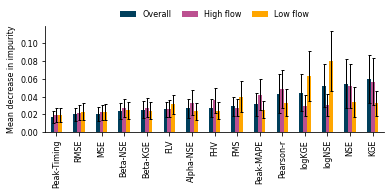

In [14]:
# Take mean feature importance across the folds
forest_importances = pd.DataFrame({(i, task): pd.Series(model.feature_importances_, index=input_vars) 
                                   for (i, task), model in models.items()}).groupby(axis=1, level=1).mean()
std = pd.DataFrame({(i, task): pd.Series(np.std([tree.feature_importances_ 
                                            for tree in model.estimators_], axis=0), index=input_vars) 
                    for (i, task), model in models.items()}).groupby(axis=1, level=1).mean()

# Each metric appears twice in the importances (once for each involved model). For the plot, we reduce it to one bar
# per metric by takeing the mean of the two values.
single_metric_importances = pd.DataFrame(columns=forest_importances.columns, 
                                         index=list(set(m.replace('model_a_', '').replace('model_b_', '') 
                                                          for m in forest_importances.index)))
single_metric_std = single_metric_importances.copy()
for metric in single_metric_importances.index:
    single_metric_importances.loc[metric] = (forest_importances.loc[f'model_a_{metric}'] + forest_importances.loc[f'model_b_{metric}']) / 2
    single_metric_std.loc[metric] = (std.loc[f'model_a_{metric}'] + std.loc[f'model_b_{metric}']) / 2

single_metric_importances = single_metric_importances[['overall', 'high-flow', 'low-flow']].sort_values(by="overall")
single_metric_std = single_metric_std[['overall', 'high-flow', 'low-flow']]
rename = dict(zip(['overall', 'high-flow', 'low-flow'], ['Overall', 'High flow', 'Low flow']))
single_metric_importances = single_metric_importances.rename(rename, axis=1)
single_metric_std = single_metric_std.rename(rename, axis=1)

fig, ax = plt.subplots(figsize=(mm_to_inch(139), mm_to_inch(70)))
single_metric_importances.plot.bar(ax=ax, yerr=single_metric_std, error_kw={'alpha': 1, 'capsize': 1.5, 'elinewidth': 1}, 
                                   color=dict(zip(['Overall', 'High flow', 'Low flow'], ['#003f5c', '#bc5090', '#ffa600'])))
ax.set_ylabel("Mean decrease in impurity")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False, ncol=3, bbox_to_anchor=(0.2, 1, 0.6, 0), loc="lower left", mode="expand")

plt.tight_layout()
plt.savefig('figures/feature-importance.pdf', bbox_inches='tight')